# nnn-2023-statics
From downloading, parsing, labeling, training, classifying and plotting — this file contains everything to create those lovely statistics you see everyday on r/NoNutNovember. The individual functions have been thouroughly documented to make them as easy to use as possible. If you have any questions regarding this notebook, either file an issue on Github or send an email to nonutnovember@ist-toll.xyz.

You can edit cells by (double) clicking them, run them with the "play" icon in the toolbar or using "Ctrl-Enter". Command output will be displayed below the according cell.

## Table of Contents
1. [Requirements](#Requirements)
2. [Setup](#Setup)
3. [Retrieve Comments and create dataset](#Retrieve-Comments-and-create-dataset)
4. [Generate Labeled Data](#Generate-Labeled-Data)
5. [Create Naive Bayes Dictionary](#Create-Naive-Bayes-Dictionary)
6. [Naive Bayes Classification](#Naive-Bayes-Classification)
7. [Naive Bayes Playground](#Naive-Bayes-Playground)
8. [Benchmark](#Benchmark)
9. [Evaluate a given Day](#Evaluate-a-given-Day)
10. [Confirm Unsures](#Confirm-Unsures)
11. [Plot the results](#Plot-the-Results)

## Requirements
To run, this project needs the following dependencies:
- Python 3
- Jupyter Notebook
- PRAW
- Matplotlib
- Numpy

## Setup
This code needs to be executed everytime before doing anything else. If another cell throws an error about missing definitions, make sure you've executed this cell before anything else.

In [15]:
import json
import random
import csv
import os
import datetime
import string
import math

DAY = 10 # update this with yesterday's date
YEAR = 2023 # update this with the current year

with open("naive_bayes.json", "r") as naive_bayes_file:
    naive_bayes_dict = json.load(naive_bayes_file)

def split_sentence(sentence):
    words = sentence.split()
    sentence = [word.strip(string.punctuation) for word in words]
    sentence = [word.lower() for word in sentence]
    return sentence

In the next cell, you need to fill in your Reddit API credentials. The key can be created at [https://old.reddit.com/prefs/apps/](https://old.reddit.com/prefs/apps/), select "script" as Key Type.

Please keep in mind, that because of the recent changes to the API terms of use, you can now only make [100 requests per minute](https://www.reddit.com/r/redditdev/comments/14nbw6g/updated_rate_limits_going_into_effect_over_the/) with having to pay. PRAW will take care of this automatically, but please be patient when pulling the data takes several minutes.

In [2]:
API_CLIENT_ID = "your_api_client_id_here"
API_CLIENT_SECRET = "your_api_client_secret_her"

## Retrieve Comments and create dataset
At the beginning of everyday, retrieve the comments of the now closed rollcall from the previous day. Adjust the parameters in the second cell to reflect "yesterdays" date. The resulting unlabeled datasets will be availabel under datasets/YEAR/DAY/USERNAME-day-DAY.csv

In [17]:
import praw
from praw.models import MoreComments

def retrieve_rollcall(day, year):
    reddit = praw.Reddit(
        client_id=API_CLIENT_ID,
        client_secret=API_CLIENT_SECRET,
        user_agent="Python script",
    )
    reddit.read_only = True
    subreddit = reddit.subreddit("nonutnovember")

    date_min = int(datetime.datetime(year, 11, day, 0, 0).strftime("%s"))
    date_max = int(datetime.datetime(year, 11, day, 23, 59).strftime("%s"))

    if year == 2022 or year == 2023:
        flair_name = "\"🗳️ Official Roll-Call\""
    else:
        print("unsupported year!")
        return

    for submission in subreddit.search(f"flair_name: {flair_name}", sort="new"):
        if date_min <= submission.created_utc <= date_max:
            print(submission.title)
            requested_rollcall_post = submission

    all_comments = []
    
    requested_rollcall_post.comments.replace_more(limit=None)
    for comment in requested_rollcall_post.comments:
        if isinstance(comment, MoreComments):
            continue
        if comment.author == None:
            continue

        all_comments.append({
                                "username": comment.author.name,
                                "text": comment.body
                            })

    all_comments_json = json.dumps(all_comments)

    with open(f"comments/{year}/{day}.json", "w") as file:
        file.write(all_comments_json)

def create_unmarked_datasets(volunteers, day, year):
    with open(f"comments/{year}/{day}.json", "r") as file:
        comments = json.load(file)
    
    random.shuffle(comments)

    for (i, username) in enumerate(volunteers):
        directory = f"datasets/{year}/{day}"
        if not os.path.exists(directory):
            os.makedirs(directory)

        filename = directory + f"/{username}-day-{day}.csv"
        with open(filename, "w") as csvfile:
            filewriter = csv.writer(csvfile, delimiter=",",
                                    quotechar="|", quoting=csv.QUOTE_MINIMAL)
            for i in range(i*DATASET_SIZE,(i+1)*DATASET_SIZE):
                filewriter.writerow([comments[i]["text"], "unknown"])

In [18]:
print("Retrieving rollcall comments...")

rollcall_day = DAY
retrieve_rollcall(rollcall_day, YEAR)

DATASET_SIZE = 100
VOLUNTEERS = ["FraglicherKopierer"]
create_unmarked_datasets(VOLUNTEERS, rollcall_day, YEAR)

print("Done!")

Retrieving rollcall comments...
11 NOVEMBER 2023 (ROLL CALL, IMPORTANT INFORMATION BELOW)
Done!


Label the datasets before continuing with the next step.

## Generate Labeled Data

In [19]:
from glob import glob

def generate_labeled_json():
    files = [y for x in os.walk("datasets") for y in glob(os.path.join(x[0], "*.csv"))]

    labeled_comments = []

    for file in files:
        with open(file, "r") as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=",", quotechar="|", quoting=csv.QUOTE_MINIMAL)

            for row in csv_reader:
                if row[1] != "n" and row[1] != "y":
                    continue

                is_positive = row[1] == "y"

                labeled_comments.append({
                                     "text": row[0],
                                     "positive": is_positive,
                                 })

    with open("labeled_comments.json", "w") as labeled_comments_file:
        labeled_comments_file.write(json.dumps(labeled_comments, indent=4))

def add_sentence_to_frequency_dict(sentence, frequency_dict, is_positive):
    if is_positive:
        key = "positive_words"
        other_key = "negative_words"
    else:
        key = "negative_words"
        other_key = "positive_words"

    for word in sentence:
        if word not in frequency_dict[key]:
            frequency_dict[key][word] = 0
        if word not in frequency_dict[other_key]:
            frequency_dict[other_key][word] = 0

        frequency_dict[key][word] += 1

    return frequency_dict

def create_frequency_dict():
    frequency_dict = {
        "positive_count": 0,
        "negative_count": 0,
        "positive_words": {},
        "negative_words": {},
    }
    
    with open("labeled_comments.json", "r") as labels:
        labels_json = json.loads(labels.read())

    for line in labels_json:
        sentence = split_sentence(line["text"])

        frequency_dict = add_sentence_to_frequency_dict(sentence, frequency_dict, line["positive"])

        if line["positive"]:
            frequency_dict["positive_count"] += len(sentence)
        else:
            frequency_dict["negative_count"] += len(sentence)

    frequency_dict["positive_words"] = sorted(frequency_dict["positive_words"].items(), key=lambda k:k [1], reverse=True)
    frequency_dict["negative_words"] = sorted(frequency_dict["negative_words"].items(), key=lambda k:k [1], reverse=True)

    with open("vocabulary.json", "w") as vocabulary:
        vocabulary.write(json.dumps(frequency_dict, indent=4))

In [20]:
generate_labeled_json()
create_frequency_dict()

## Create Naive Bayes Dictionary
When using Naive Bayes, the training data set will be split into it's individual words. The positive and negative frequency of each word will be counted in a dictionary. These frequencies will then be turned into lamdba values and the sum of a sentence's lambda values will create its score.

The formular for a word's lambda value is:
$$
\lambda(word)=log(\frac{P(word|pos)}{P(word|neg)})
$$

The formular for log prior (bias) is:
$$
log_prior = log(\frac{P(pos)}{P(neg)})
$$

I can really recommend the [Supervised ML & Sentiment Analysis Coursera Cours](https://www.coursera.org/learn/classification-vector-spaces-in-nlp/lecture/QYcqq/supervised-ml-sentiment-analysis), which can be viewed for free.

In [21]:
with open("vocabulary.json", "r") as vocabulary:
    word_counts = json.loads(vocabulary.read())

naive_bayes_dict = {
    "prior_ratio": word_counts["positive_count"] / word_counts["negative_count"],
    "log_prior": math.log(word_counts["positive_count"] / word_counts["negative_count"]),
    "positive_probabilities": {},
    "negative_probabilities": {},
    "lambda": {},
}

positive_count = word_counts["positive_count"]
positive_count_unique = len(word_counts["positive_words"])
for (word, count) in word_counts["positive_words"]:
    naive_bayes_dict["positive_probabilities"][word] = (count + 1) / (positive_count + positive_count_unique)

negative_count = word_counts["negative_count"]
negative_count_unique = len(word_counts["positive_words"])
for (word, count) in word_counts["negative_words"]:
    naive_bayes_dict["negative_probabilities"][word] = (count + 1) / (negative_count + negative_count_unique)

for word in naive_bayes_dict["positive_probabilities"]:
    positive_probability = naive_bayes_dict["positive_probabilities"][word]
    negative_probability = naive_bayes_dict["negative_probabilities"][word]

    naive_bayes_dict["lambda"][word] = math.log(positive_probability / negative_probability)

with open("naive_bayes.json", "w") as naive_bayes_file:
    naive_bayes_file.write(json.dumps(naive_bayes_dict, indent=4))

## Naive Bayes Classification

The formular for a whole sentence is:
$$
log(\frac{P(pos)}{P(neg)}) + \sum_{i=1}^{m} \lambda(word_i)
$$

A positive value means a positive sentiment (the user is "still in"), a negative value means a negative sentiment (the user is "out").

This threshold (0) could be adjusted generate a dataset with the more unsure dataset entries.

In [22]:
def classify_sentence(sentence, naive_bayes_dict, threshold=0):
    sum = naive_bayes_dict["log_prior"]

    for word in sentence:
        if word not in naive_bayes_dict["positive_probabilities"]:
            continue
        
        # use log likelyhood
        sum += naive_bayes_dict["lambda"][word]

    if sum >= threshold:
        return True

    return False

def test_against_labeled_dataset(test=[True, False]):
    with open("naive_bayes.json", "r") as naive_bayes_file:
        naive_bayes_dict = json.loads(naive_bayes_file.read())

    with open("testset.json", "r") as labeled_file:
        labeled_comments = json.loads(labeled_file.read())

    total = 0
    correct = 0

    for comment in labeled_comments:
        if comment["positive"] not in test:
            continue

        total += 1
        
        sentence = split_sentence(comment["text"])

        if classify_sentence(sentence, naive_bayes_dict) == comment["positive"]:
            correct += 1

    return correct / total

# get the upper and lower error margins for comments that say "i'm out"
def get_error_margins_for_out():
    positives_correct = test_against_labeled_dataset([True])
    positives_false = 1 - positives_correct # comments that were labeled as "in" but are actually "out" (upper bound)

    negatives_correct = test_against_labeled_dataset([False])
    negatives_false = 1 - negatives_correct # comments that were labeled as "out" but are actualyl "in" (lower bound)

    return (negatives_false, positives_false)

## Naive Bayes Playground

Try some values to see if they are classified correctly:

In [10]:
if classify_sentence(split_sentence(input()), naive_bayes_dict):
    print("The classifier said: \x1b[32m\"The user is still in\"\x1b[0m")
else:
    print("The classifier said: \x1b[31m\"The user is out.\"\x1b[0m")

 My wife is tempting me but im still in


The classifier said: "The user is still in"


## Benchmark

Compare the classification results against the labeled dataset to find out how accurate the classifier is. Values over 90% are desirable.

In [23]:
accuracy = test_against_labeled_dataset(test=[True])
accuracy_percent = '%.2f'%(accuracy * 100)
print(f"The classifier is {accuracy_percent}% correct for \"in\".")

    
accuracy = test_against_labeled_dataset(test=[False])
accuracy_percent = '%.2f'%(accuracy * 100)
print(f"The classifier is {accuracy_percent}% correct for \"out\".")

accuracy = test_against_labeled_dataset(test=[True, False])
accuracy_percent = '%.2f'%(accuracy * 100)
print(f"The classifier is {accuracy_percent}% correct in total.")

The classifier is 99.78% correct for "in".
The classifier is 94.29% correct for "out".
The classifier is 99.72% correct in total.


## Evaluate a given Day
Run the classifier against all comments from a given day and find out how many people commented that they are "out".

In [24]:
def get_outs_at_day(year, day):
    if day == 30 and year == 2022: # last day has a few more false negatives, I counted this value manually
        return 17
    
    with open(f"comments/{year}/{day}.json", "r") as file:
        comments = json.load(file)

    number_of_outs = 0
    for comment in comments:
        sentence = split_sentence(comment["text"])
        if not classify_sentence(sentence, naive_bayes_dict):
            number_of_outs += 1

    return number_of_outs

## Confirm Unsures
Especially during the first and last day, there might be lots ambigious comments that Naive Bayes has problems classifying. To avoid this problem, generate a dataset with every comment below a certain threshold (let's say: 2) and label it manually.

In [24]:
def confirm_unsures(year, day):
    with open(f"comments/{year}/{day}.json") as file:
        comments = json.load(file)

    csvfile = open(f"datasets/{year}/day-{day}-unsures.csv", "w")
    csvwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)

    for comment in comments:
        if not classify_sentence(split_sentence(comment["text"]), naive_bayes_dict, threshold=2):
            csvwriter.writerow([comment["text"], "unknown"])

    file.close()

In [25]:
confirm_unsures(2023, 1)

## Plot the Results
Once all the results are in, create a beatiful graph using Matplotlib! I'm using bar charts to track the progress because each bar represents a single group of users.

The benchmark is used to create error margins which will be included in the graph.

In [25]:
(lower_error_margin, upper_error_margin) = get_error_margins_for_out()

days_data = []
yerr = [
    [],
    []
]

for day in range(1,DAY+1):
    outs = get_outs_at_day(YEAR, day)
    days_data.append(outs)
    yerr[0].append(outs * (lower_error_margin))
    yerr[1].append(outs * (upper_error_margin))
            
labels = range(1,DAY+1)

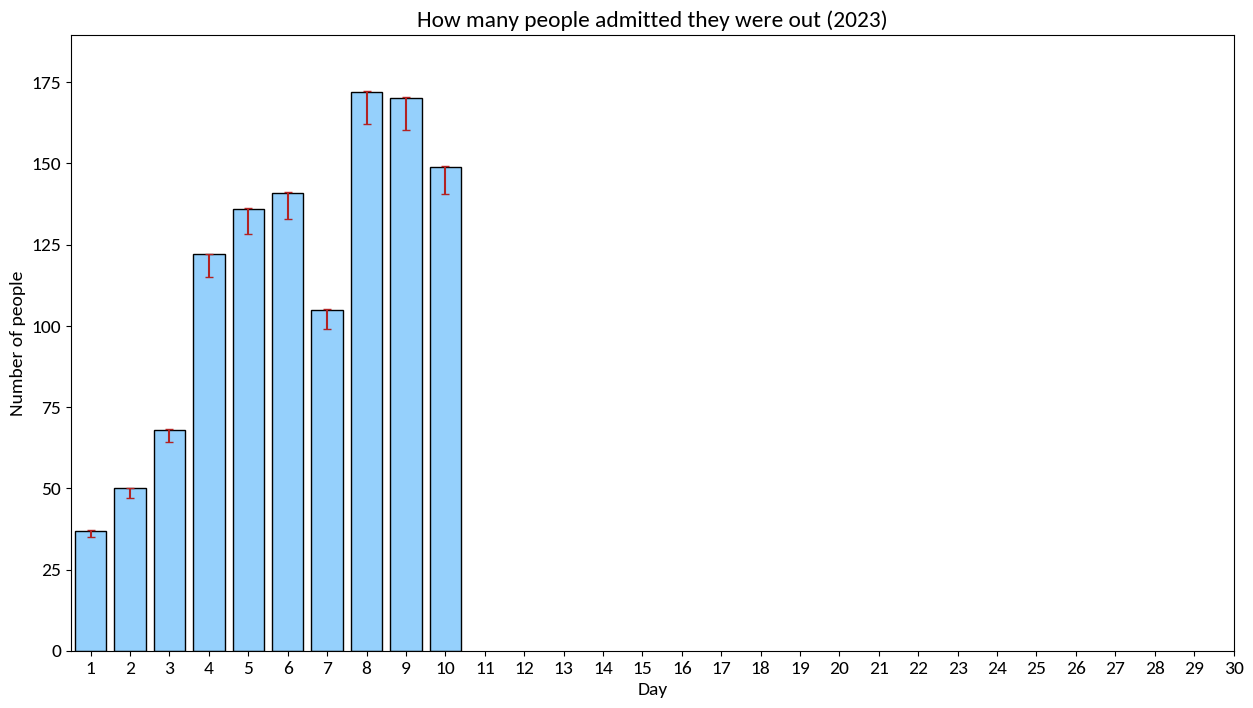

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

plt.rcParams["font.family"] = "Carlito"
plt.rcParams["font.size"] = 14

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(8)
plt.margins(x=0.01, y=0.1)


ax = plt.bar(labels, days_data, path_effects=[pe.Stroke(linewidth=1, foreground="black")], color="#95d0fc")
plt.errorbar(labels, days_data, yerr=yerr, capsize=3, fmt="none", ecolor="firebrick")
plt.xticks(np.arange(1, 31, 1.0))

plt.xlabel("Day")
plt.ylabel("Number of people")
plt.title(f"How many people admitted they were out ({YEAR})")
    
plt.savefig(f"graphs/{YEAR}-day-{DAY}-outs.jpeg", dpi=300)
plt.show()